In [2]:
# Importing required libraries
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
#from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [3]:
# Importing store data
df_revenue = pd.read_csv('fake_clinic_data_extract_test (1).csv')
df_revenue.head()

,appointment_date,clinic_name,patient_id,practitioner_id,appointment_duration_min,revenues_from_appointment
0,2021-12-30,clinic_2,70172,1030,30,98.13
1,2021-12-29,clinic_1,53371,756,15,65.13
2,2021-12-29,clinic_2,69545,1030,30,105.18
3,2021-12-27,clinic_1,43859,756,30,58.11
4,2021-12-23,clinic_1,69303,756,30,119.00


In [4]:
#string to date format
df_revenue['Month'] = pd.to_datetime(df_revenue['appointment_date'],infer_datetime_format=True)
df_revenue.head(5)

,appointment_date,clinic_name,patient_id,practitioner_id,appointment_duration_min,revenues_from_appointment,Month
0,2021-12-30,clinic_2,70172,1030,30,98.13,2021-12-30
1,2021-12-29,clinic_1,53371,756,15,65.13,2021-12-29
2,2021-12-29,clinic_2,69545,1030,30,105.18,2021-12-29
3,2021-12-27,clinic_1,43859,756,30,58.11,2021-12-27
4,2021-12-23,clinic_1,69303,756,30,119.00,2021-12-23


In [5]:
df_revenue_1 = df_revenue.copy()

In [6]:
df_revenue.isnull().sum() #check for null values (375 present in the dataset)

appointment_date               0
clinic_name                    0
patient_id                     0
practitioner_id                0
appointment_duration_min       0
revenues_from_appointment    375
Month                          0
dtype: int64

In [7]:
df_revenue.shape

(4071, 7)

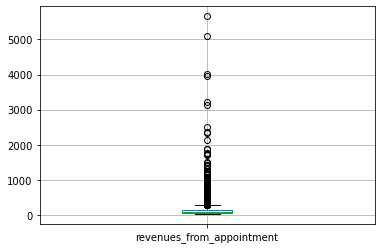

In [8]:
#Considering the boxplot here, it gives a clear picture that majority of the data lies below 1000, and there are quite some outliers

df_revenue.boxplot(['revenues_from_appointment']); 

In [9]:
#Replaced null values with median
df_revenue.fillna(df_revenue['revenues_from_appointment'].median(), inplace=True)
print(df_revenue)

     appointment_date clinic_name  patient_id  practitioner_id  \
0          2021-12-30    clinic_2       70172             1030   
1          2021-12-29    clinic_1       53371              756   
2          2021-12-29    clinic_2       69545             1030   
3          2021-12-27    clinic_1       43859              756   
4          2021-12-23    clinic_1       69303              756   
...               ...         ...         ...              ...   
4066       2021-08-19    clinic_1       44907              755   
4067       2021-09-02    clinic_1       45056              757   
4068       2021-08-19    clinic_1       44919              757   
4069       2021-07-22    clinic_1       45055              755   
4070       2021-07-22    clinic_1       44912              755   

      appointment_duration_min  revenues_from_appointment      Month  
0                           30                      98.13 2021-12-30  
1                           15                      65.13 2021-12

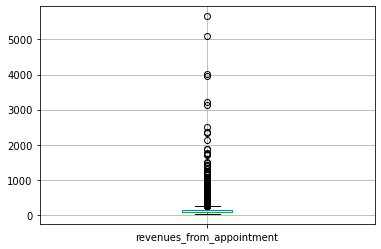

In [10]:
df_revenue.boxplot(['revenues_from_appointment']); 

In [11]:
df_revenue.isnull().sum() # No null values now

appointment_date             0
clinic_name                  0
patient_id                   0
practitioner_id              0
appointment_duration_min     0
revenues_from_appointment    0
Month                        0
dtype: int64

In [12]:
#groupby date and sum the revenue values
df_revenue = df_revenue.groupby('Month').revenues_from_appointment.sum().reset_index()

In [13]:
df_revenue.head() #aggregating all the dates with the sum of the revenues

,Month,revenues_from_appointment
0,2021-06-28,1622.54
1,2021-06-29,1052.20
2,2021-06-30,891.24
3,2021-07-01,443.66
4,2021-07-02,443.55


In [14]:
df_revenue = df_revenue.set_index(['Month']) #Month is set as the index
df_revenue.head(5)

,revenues_from_appointment
Month,
2021-06-28,1622.54
2021-06-29,1052.20
2021-06-30,891.24
2021-07-01,443.66
2021-07-02,443.55


In [15]:
df_revenue['revenues_from_appointment'].describe()

count      132.000000
mean      4800.985000
std       2470.315604
min        443.550000
25%       3008.662500
50%       4550.595000
75%       6022.815000
max      12699.030000
Name: revenues_from_appointment, dtype: float64

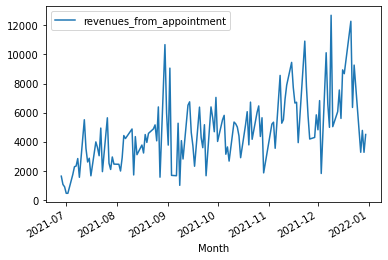

In [16]:
df_revenue.plot();

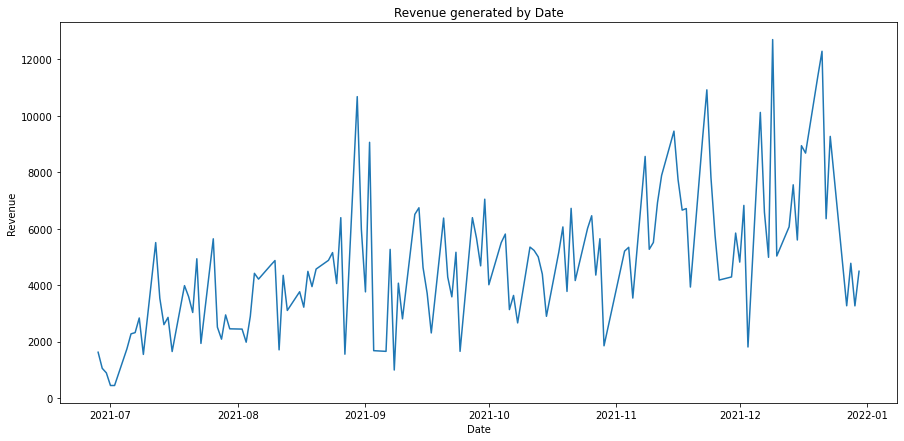

In [17]:
plt.figure(figsize=(15,7))
plt.title("Revenue generated by Date")
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.plot(df_revenue['revenues_from_appointment'])
plt.show()

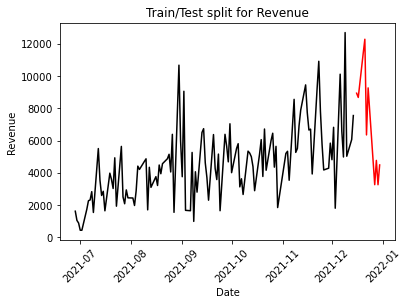

In [18]:
train = df_revenue[df_revenue.index < pd.to_datetime("2021-12-15", format='%Y-%m-%d')]
test = df_revenue[df_revenue.index > pd.to_datetime("2021-12-15", format='%Y-%m-%d')]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Revenue")
plt.show()

Autoregressive Moving Average (ARMA)

In [19]:
#Input
y = train['revenues_from_appointment']

In [40]:
ARMAmodel = SARIMAX(y, order = (1, 0, 2))

In [41]:
ARMAmodel = ARMAmodel.fit()

In [42]:
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out_arma = y_pred_df["Predictions"] 

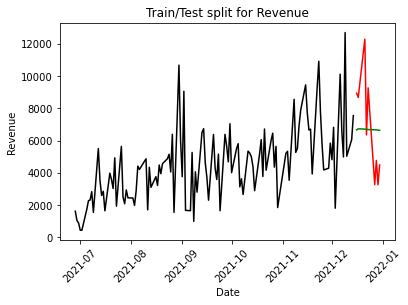

In [43]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(y_pred_out_arma, color='green', label = 'Predictions');
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Revenue")
plt.show()

In [45]:
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test["revenues_from_appointment"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  3165.2518919647223


Autoregressive Integrated Moving Average (ARIMA)

In [46]:
from statsmodels.tsa.arima.model import ARIMA

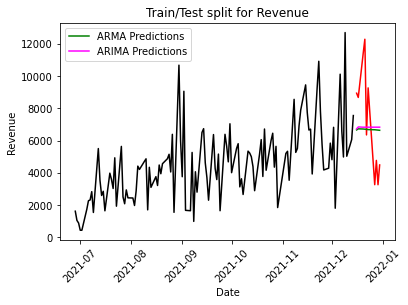

In [50]:
ARIMAmodel = ARIMA(y, order = (1, 1, 1))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out_arima = y_pred_df["Predictions"] 
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(y_pred_out_arma, color='green', label = 'ARMA Predictions')
plt.plot(y_pred_out_arima, color='Magenta', label = 'ARIMA Predictions')
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Revenue")
plt.legend()

In [51]:
arima_rmse = np.sqrt(mean_squared_error(test["revenues_from_appointment"].values, y_pred_out_arima))
print("RMSE: ",arima_rmse)

RMSE:  3167.2338844832307


Seasonal ARIMA (SARIMA)

In [52]:
SARIMAXmodel = SARIMAX(y, order = (2, 2, 4), seasonal_order=(2,2,2,9))

In [62]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [63]:
smodel = pm.auto_arima(train['revenues_from_appointment'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2018.883, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2006.223, Time=0.30 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2020.850, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2020.796, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1998.342, Time=0.71 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.57 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1995.980, Time=0.62 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=2004.365, Time=0.29 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1998.044, Time=0.60 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1997.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                  121
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood                -993.990
Date:                  Wed, 08 Jun 2022   AIC                           1995.980
Time:                          20:27:33   BIC                           2006.745
Sample:                               0   HQIC                          2000.345
                                  - 121                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    821.0073    240.125      3.419      0.001     350.370    1291.644
ar.S.L12      -0.4979      0.087     -5.713      0.000      -0.669      -0.327
ar.S.L24      -0.3310      0.112     -2.962      0.003      -0.550      -0.112
sigma2      4.464e+06   5.82e+05      7.665      0.000    3.32e+06    5.61e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 1.10
Prob(Q):                              0.68   Prob(JB):                         0.58
Heteroskedasticity (H):               1.75   Skew:                             0.25
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

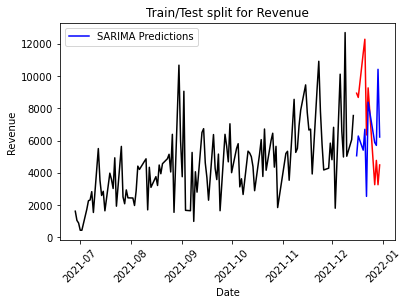

In [71]:
SARIMAXmodel = SARIMAX(y, order = (0,0,0), seasonal_order=(2,1,0,12))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out_sarima = y_pred_df["Predictions"] 
plt.plot(train, color = "black")
plt.plot(test, color = "red")
#plt.plot(y_pred_out_arma, color='green', label = 'ARMA Predictions')
#plt.plot(y_pred_out_arima, color='Magenta', label = 'ARIMA Predictions')
plt.plot(y_pred_out_sarima, color='Blue', label = 'SARIMA Predictions')
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Revenue")
plt.legend()



In [70]:
sarima_rmse = np.sqrt(mean_squared_error(test["revenues_from_appointment"].values, y_pred_out_sarima))
print("RMSE: ",sarima_rmse)

RMSE:  4048.4437755288163


RMSE of SARIMA < ARMA < ARIMA

In [8]:
# ADF stationarity test
# Returns: {Test statistic, P-value, Num lags used, {Critical values}, Estmation of maximized information criteria}
from statsmodels.tsa.stattools import adfuller

adfuller(df_revenue['revenues_from_appointment'])

(-1.9072746894428707,
 0.328646644332926,
 9,
 122,
 {'1%': -3.4851223522012855,
  '5%': -2.88553750045158,
  '10%': -2.5795685622144586},
 2128.743713454084)

In [10]:
#create a new dataframe to model the difference
df_diff = df_revenue.copy()
#add previous sales to the next row
df_diff['prev_revenue'] = df_diff['revenues_from_appointment'].shift(1)
#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['revenues_from_appointment'] - df_diff['prev_revenue'])
df_diff.head(10)

,date,revenues_from_appointment,prev_revenue,diff
1,2021-06-29,947.73,1622.54,-674.81
2,2021-06-30,891.24,947.73,-56.49
3,2021-07-01,443.66,891.24,-447.58
4,2021-07-02,443.55,443.66,-0.11
5,2021-07-05,1741.69,443.55,1298.14
6,2021-07-06,2273.98,1741.69,532.29
7,2021-07-07,2108.17,2273.98,-165.81
8,2021-07-08,2731.24,2108.17,623.07
9,2021-07-09,1545.44,2731.24,-1185.80
10,2021-07-12,5402.62,1545.44,3857.18


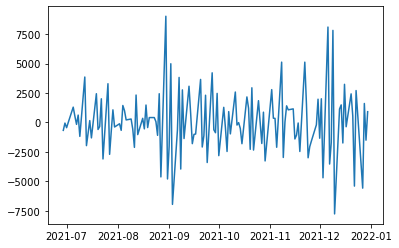

In [11]:
plt.plot(df_diff['date'], df_diff['diff']);